In [1]:
!pip install seaborn 

pip: Command not found.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import numpy as np
from datetime import datetime
import seaborn as sns

In [4]:
# Define the file path and answer types
file_path = '/Users/poppbi/work/privacyqa_offline_evaluation/calculate_percentages_at_least_as_good_as_human'
answer_types = ['Designed_Answer_1', 'Designed_Answer_2', 'Rag','Rag_Rain_comp', 'Rag_Rain_dishon']

# Initialize an empty dictionary to hold the data
data_dict = {answer_type: [] for answer_type in answer_types}

# Iterate over all files in the directory
for file_name in os.listdir(file_path):
    if file_name.startswith("PrivacyQA_Evaluation") and file_name.endswith(".csv"):
        # Determine the answer type based on the file name
        for answer_type in answer_types:
            if answer_type in file_name:
                # Load the CSV file into a DataFrame
                df = pd.read_csv(os.path.join(file_path, file_name))
                # Append the DataFrame to the corresponding list in the dictionary
                data_dict[answer_type].append(df)

# Concatenate all DataFrames for each answer type into a single DataFrame
data_dict = {answer_type: pd.concat(data_dict[answer_type], ignore_index=True) for answer_type in answer_types}

In [5]:
# Function to extract overall score from the string
def extract_score(score_str):
    match = re.search(r'overall score:\s*(\d+)', score_str, re.IGNORECASE)
    if match:
        return int(match.group(1))
    return None

In [6]:
# Function to clean and convert the column to integers
def convert_to_integer(value):
    match = re.search(r'\d+', str(value))
    if match:
        return int(match.group(0))
    return None

In [7]:
# Function to extract the first integer from the string, including negative numbers
def extract_first_integer(value):
    match = re.search(r'-?\d+', str(value))
    if match:
        return int(match.group(0))
    return None

In [8]:
# Function to perform data cleaning
def clean_data(df):
    # List of metrics with overall scores to extract
    metrics_with_scores = ['context_adherence', 'completeness', 'correctness', 'answer_relevancy']
    
    # Extract and format the scores as integers
    for metric in metrics_with_scores:
        df[metric] = df[metric].apply(extract_score)
    
    # Clean up and convert 'readability_LLM_eval_Trott' to integers
    df['readability_LLM_eval_Trott'] = df['readability_LLM_eval_Trott'].apply(convert_to_integer)
    df = df.dropna(subset=['readability_LLM_eval_Trott'])
    df['readability_LLM_eval_Trott'] = df['readability_LLM_eval_Trott'].astype(int)
    
    # Clean up and convert 'readability_grade' to integers
    df['readability_grade'] = df['readability_grade'].apply(extract_first_integer)
    df = df.dropna(subset=['readability_grade'])
    df['readability_grade'] = df['readability_grade'].astype(int)
    
    return df

In [9]:
# Initialize an empty dictionary to hold the data
data_dict = {answer_type: [] for answer_type in answer_types}

# Iterate over all files in the directory
for file_name in os.listdir(file_path):
    if file_name.startswith("PrivacyQA_Evaluation") and file_name.endswith(".csv"):
        # Determine the answer type based on the file name
        for answer_type in answer_types:
            if answer_type in file_name:
                # Load the CSV file into a DataFrame
                df = pd.read_csv(os.path.join(file_path, file_name))
                # Append the cleaned DataFrame to the corresponding list in the dictionary
                data_dict[answer_type].append(clean_data(df))

# Concatenate all DataFrames for each answer type into a single DataFrame
data_dict = {answer_type: pd.concat(data_dict[answer_type], ignore_index=True) for answer_type in answer_types}

In [10]:
# Create directory for cleaned data
cleaned_data_path = os.path.join(file_path, 'cleaned_data')
os.makedirs(cleaned_data_path, exist_ok=True)

# Save the cleaned data to CSV files
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
for answer_type, df in data_dict.items():
    filename = f'PrivacyQA_Evaluation_Cleaned_{answer_type}_{timestamp}.csv'
    df.to_csv(os.path.join(cleaned_data_path, filename), index=False)

In [22]:
# Calculate thresholds for each metric and each question
metrics = [
    'context_adherence', 'completeness', 'correctness', 'answer_relevancy', 
    'readability_LLM_eval_Trott', 'bleu_score', 'rouge_1', 'bert_score', 
    'readability_score', 'readability_grade', 'lexical_diversity', 'text_length'
]

# Extract the tables
df1 = data_dict['Designed_Answer_1']
df2 = data_dict['Designed_Answer_2']

# Initialize the thresholds DataFrame with the 'Question' column
thresholds = pd.DataFrame()
thresholds['Question'] = df1['Question']

# Iterate through the metrics and compute the minimum value
for metric in metrics:
    if metric in df1.columns and metric in df2.columns:
        thresholds[metric] = df1[metric].combine(df2[metric], min)

In [23]:
counts_dict = {answer_type: pd.DataFrame() for answer_type in answer_types}

# Iterate over each answer type to calculate counts
for answer_type in answer_types:
    # Initialize counts DataFrame for the current answer type
    counts = pd.DataFrame()
    counts['Question'] = thresholds['Question']

    for metric in metrics:
        counts[metric] = np.nan  # Initialize counts for each metric

        for index, row in thresholds.iterrows():
            question_id = row['Question']
            threshold_value = row[metric]

            # Check the current answer type DataFrame
            if metric in data_dict[answer_type].columns:
                df_subset = data_dict[answer_type][data_dict[answer_type]['Question'] == question_id]
                if not df_subset.empty:
                    metric_values = df_subset[metric].values
                    if len(metric_values) > 0:
                        # Handle cases where NaN values might be present
                        if pd.isna(threshold_value) or pd.isna(metric_values).any():
                            counts.at[index, metric] = np.nan
                        else:
                            # Check if all metric values are at least the threshold
                            counts.at[index, metric] = int(np.all(metric_values >= threshold_value))
                    else:
                        counts.at[index, metric] = np.nan
                else:
                    counts.at[index, metric] = np.nan
            else:
                counts.at[index, metric] = np.nan

    # Store the counts DataFrame for the current answer type in the dictionary
    counts_dict[answer_type] = counts

In [24]:
# Initialize an empty DataFrame to store percentages
percentage_df = pd.DataFrame(index=answer_types, columns=metrics)

# Iterate over each answer type and metric to compute percentages
for answer_type in answer_types:
    counts_df = counts_dict[answer_type]  # Retrieve the counts DataFrame for the current answer type
    
    for metric in metrics:
        if metric in counts_df.columns:
            # Count the number of 1s and the number of non-NaN values
            num_ones = counts_df[metric].eq(1).sum()
            num_non_nan = counts_df[metric].notna().sum()
            
            # Compute the percentage
            if num_non_nan > 0:
                percentage = (num_ones / num_non_nan) * 100
            else:
                percentage = np.nan  # If there are no non-NaN values, set the percentage to NaN
            
            # Save the percentage in the DataFrame
            percentage_df.at[answer_type, metric] = percentage

# Print the resulting percentage DataFrame
#print(percentage_df)


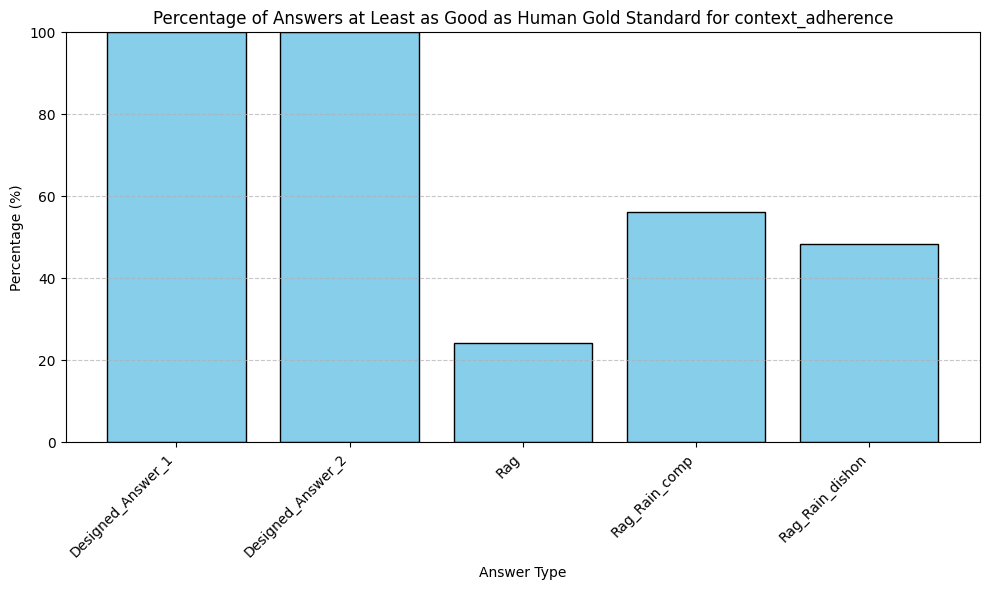

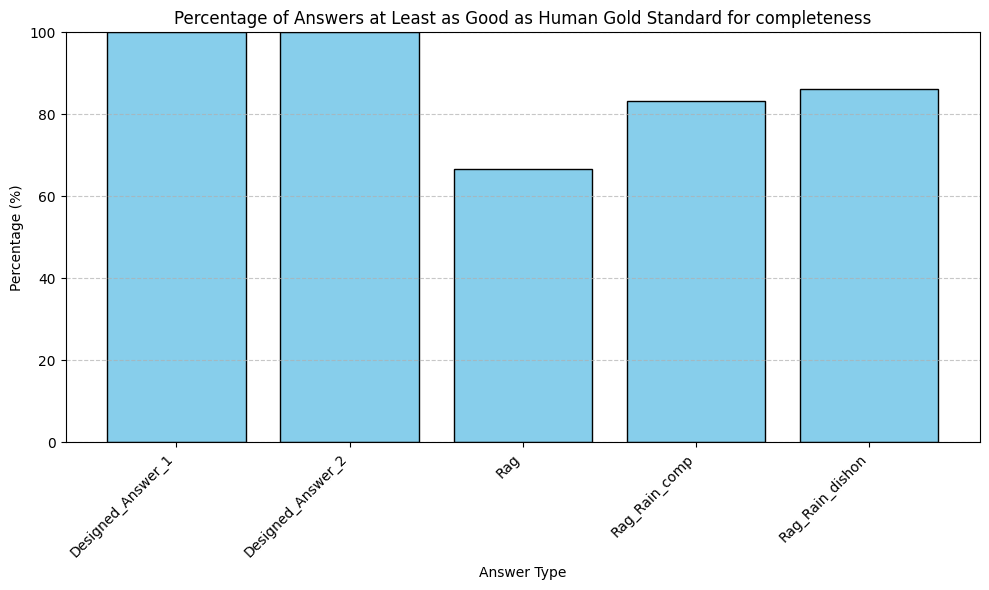

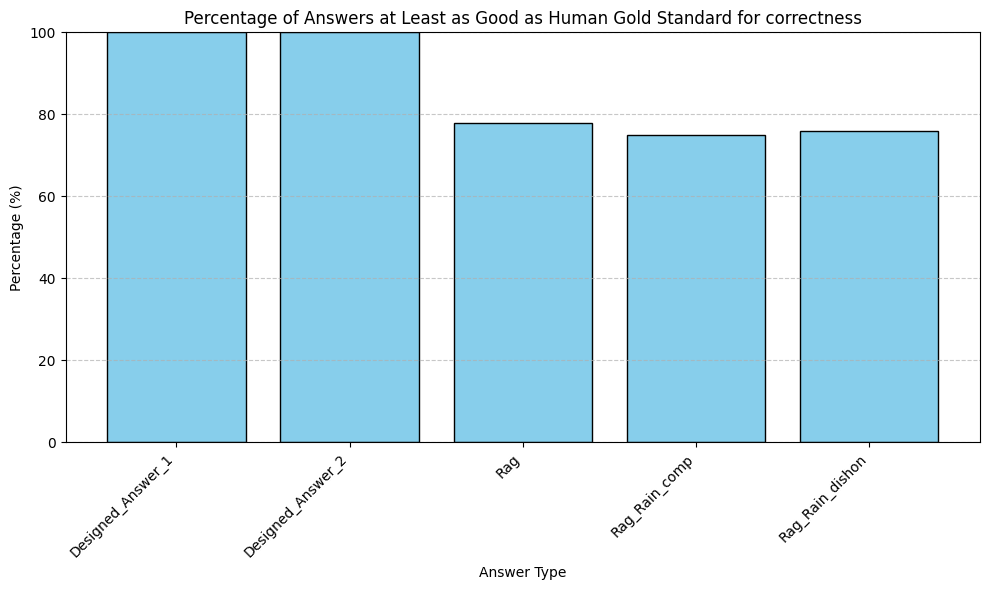

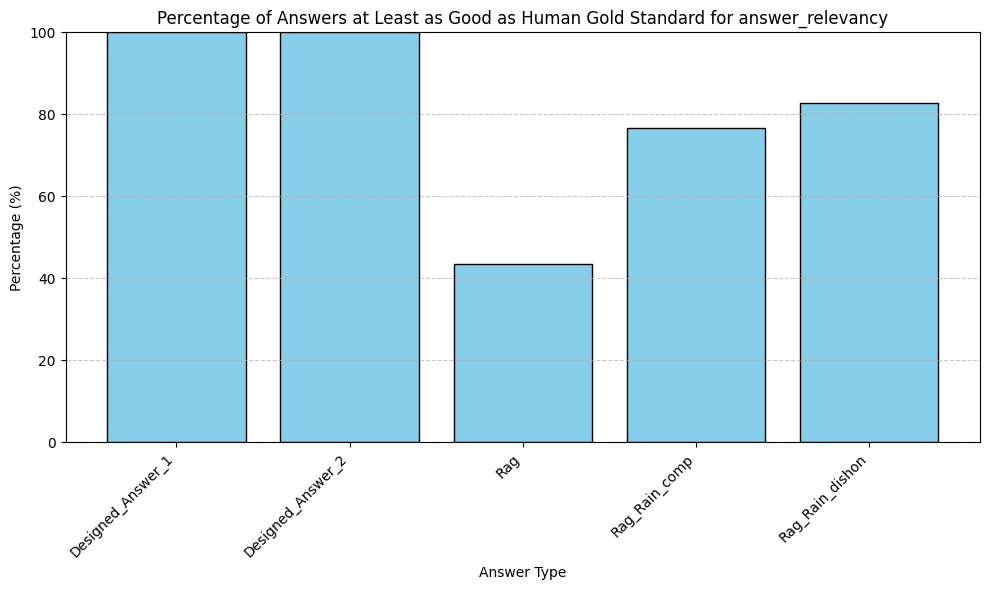

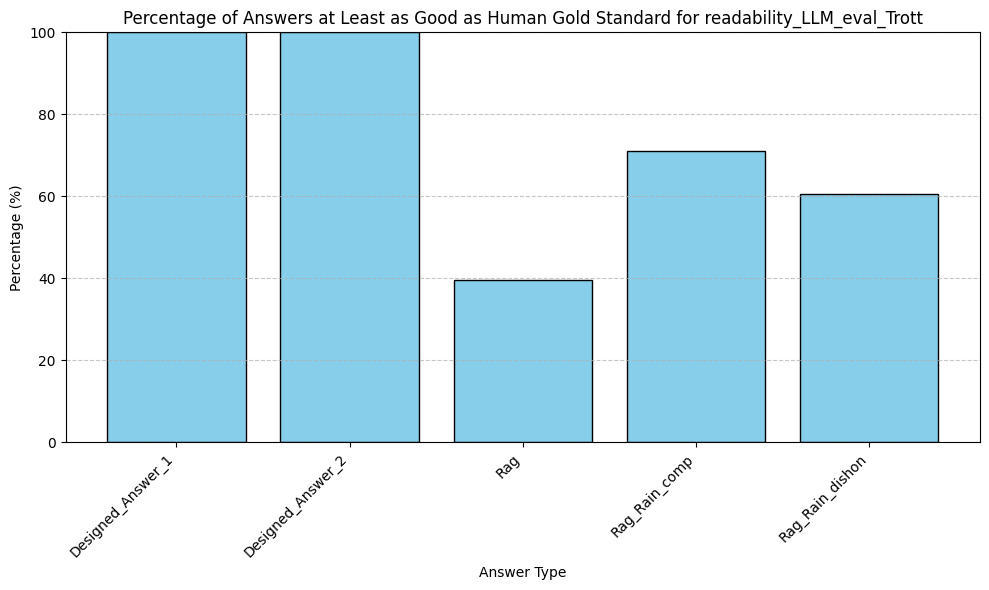

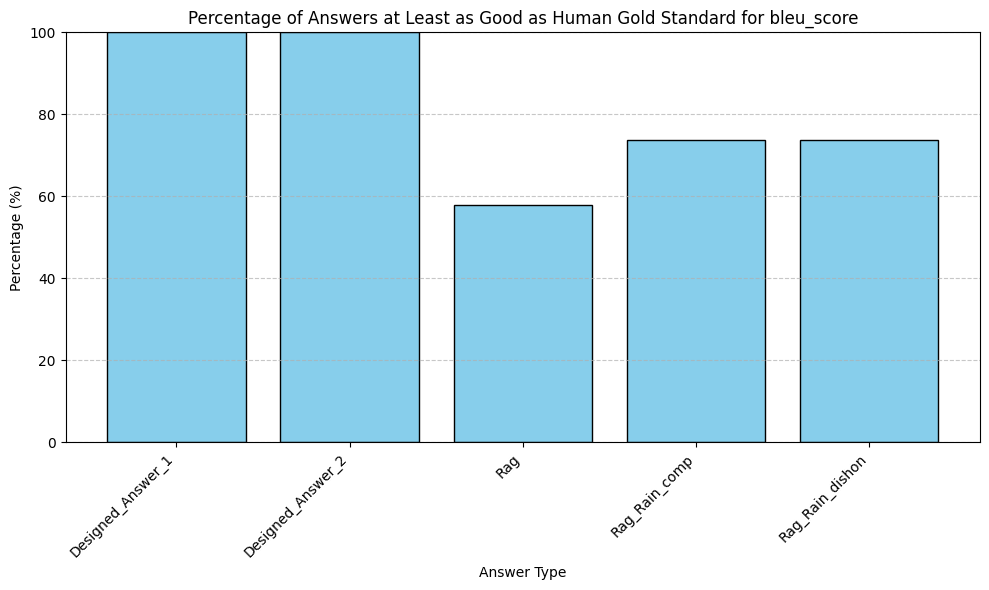

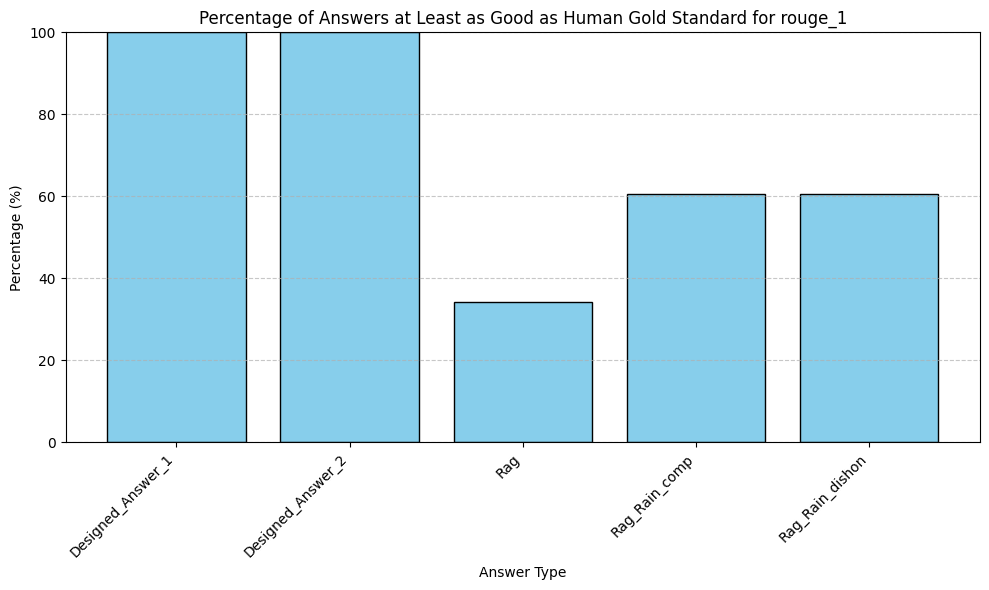

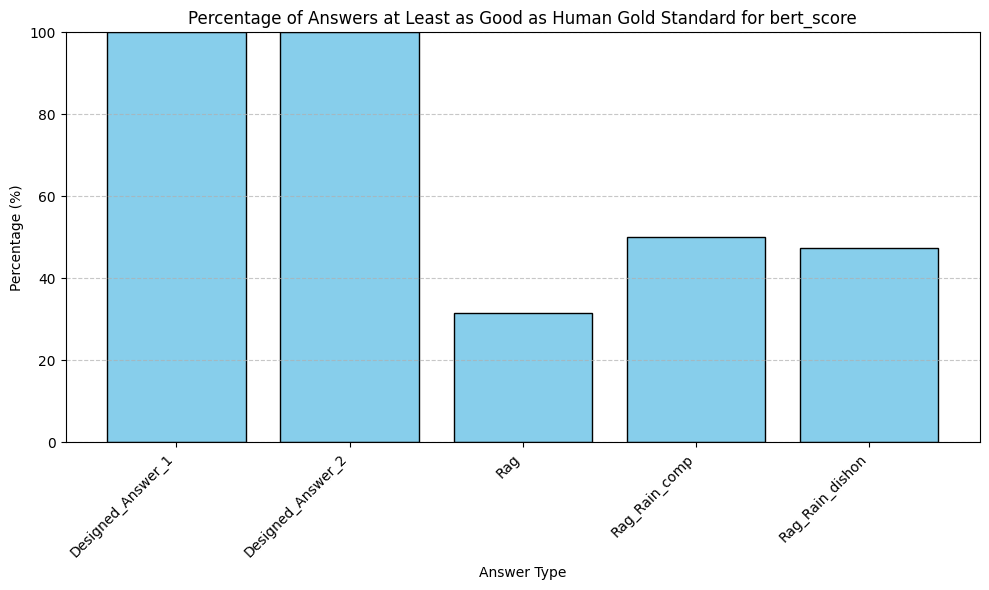

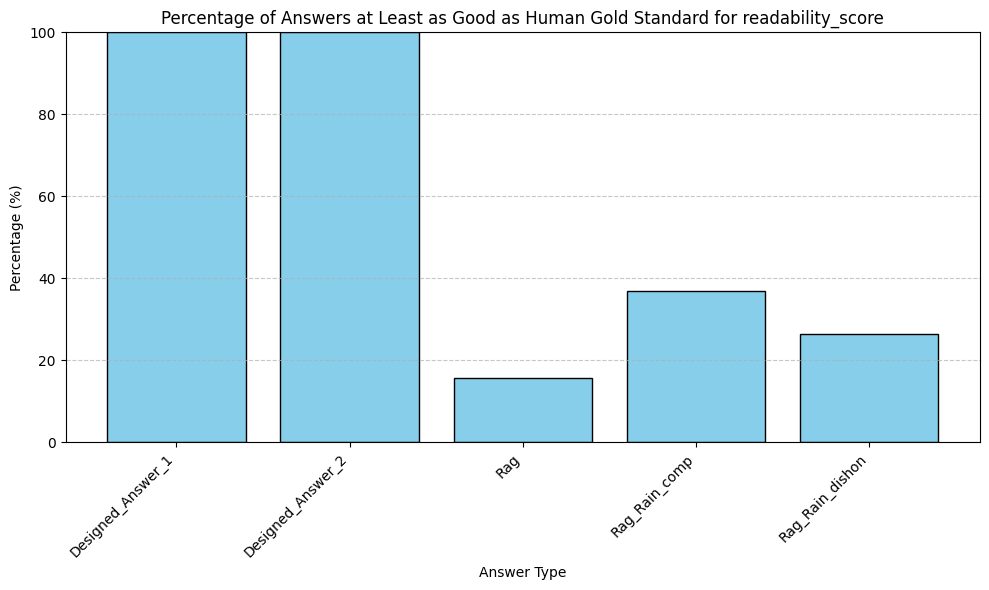

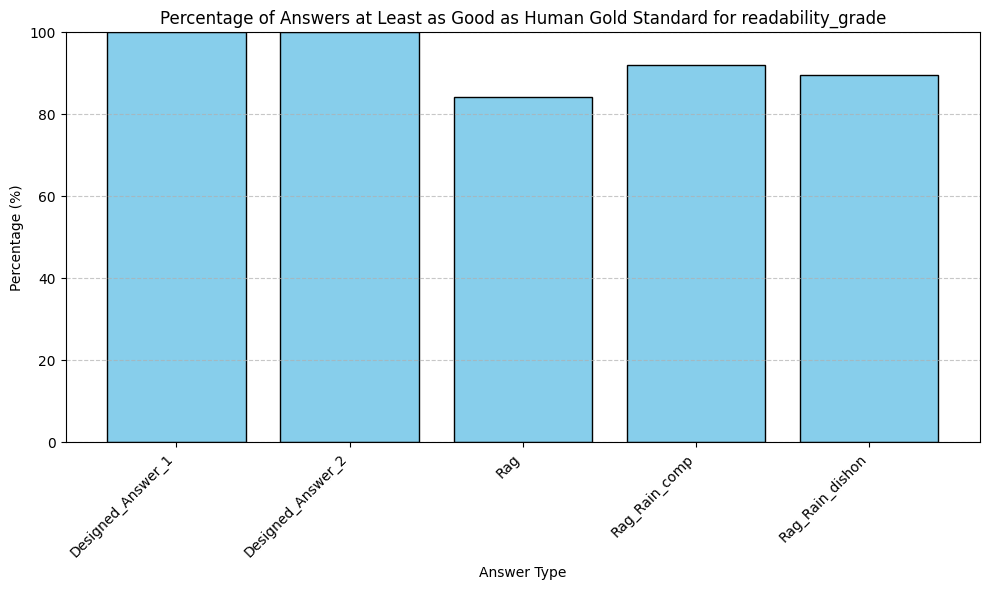

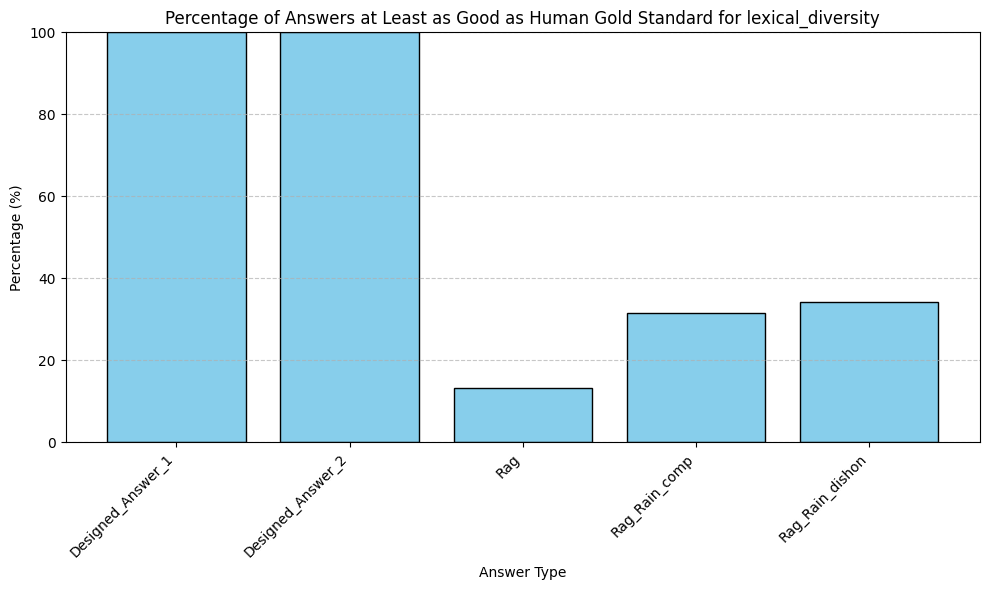

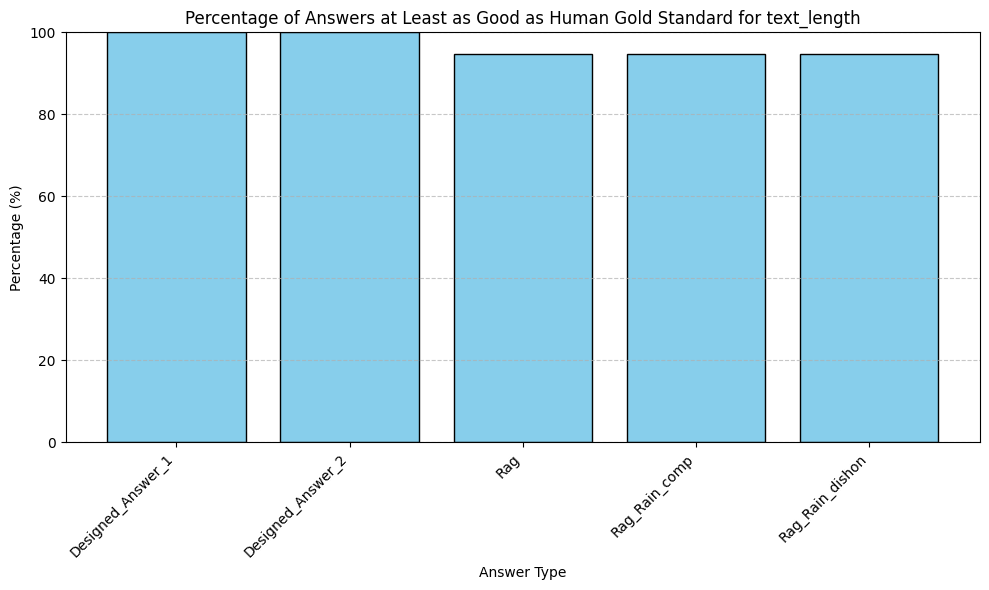

In [19]:
import matplotlib.pyplot as plt

# Plotting each metric separately
for metric in metrics:
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(percentage_df.index, percentage_df[metric], color='skyblue', edgecolor='black')
    plt.xlabel('Answer Type')
    plt.ylabel('Percentage (%)')
    plt.title(f'Percentage of Answers at Least as Good as Human Gold Standard for {metric}')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
    plt.tight_layout()  # Adjust layout to fit labels

    # Save the plot as an image file (optional)
    plt.savefig(f'{metric}_percentage_plot.png')

    # Show the plot
    plt.show()

/var/folders/2z/xb9p5x856vl3czvkkb6kr3f4bznd6r/T/ipykernel_73925/76216346.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/2z/xb9p5x856vl3czvkkb6kr3f4bznd6r/T/ipykernel_73925/76216346.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/2z/xb9p5x856vl3czvkkb6kr3f4bznd6r/T/ipykernel_73925/76216346.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/2z/xb9p5x856vl3czvkkb6kr3f4bznd6r/T/ipykernel_73925/76216346.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocat

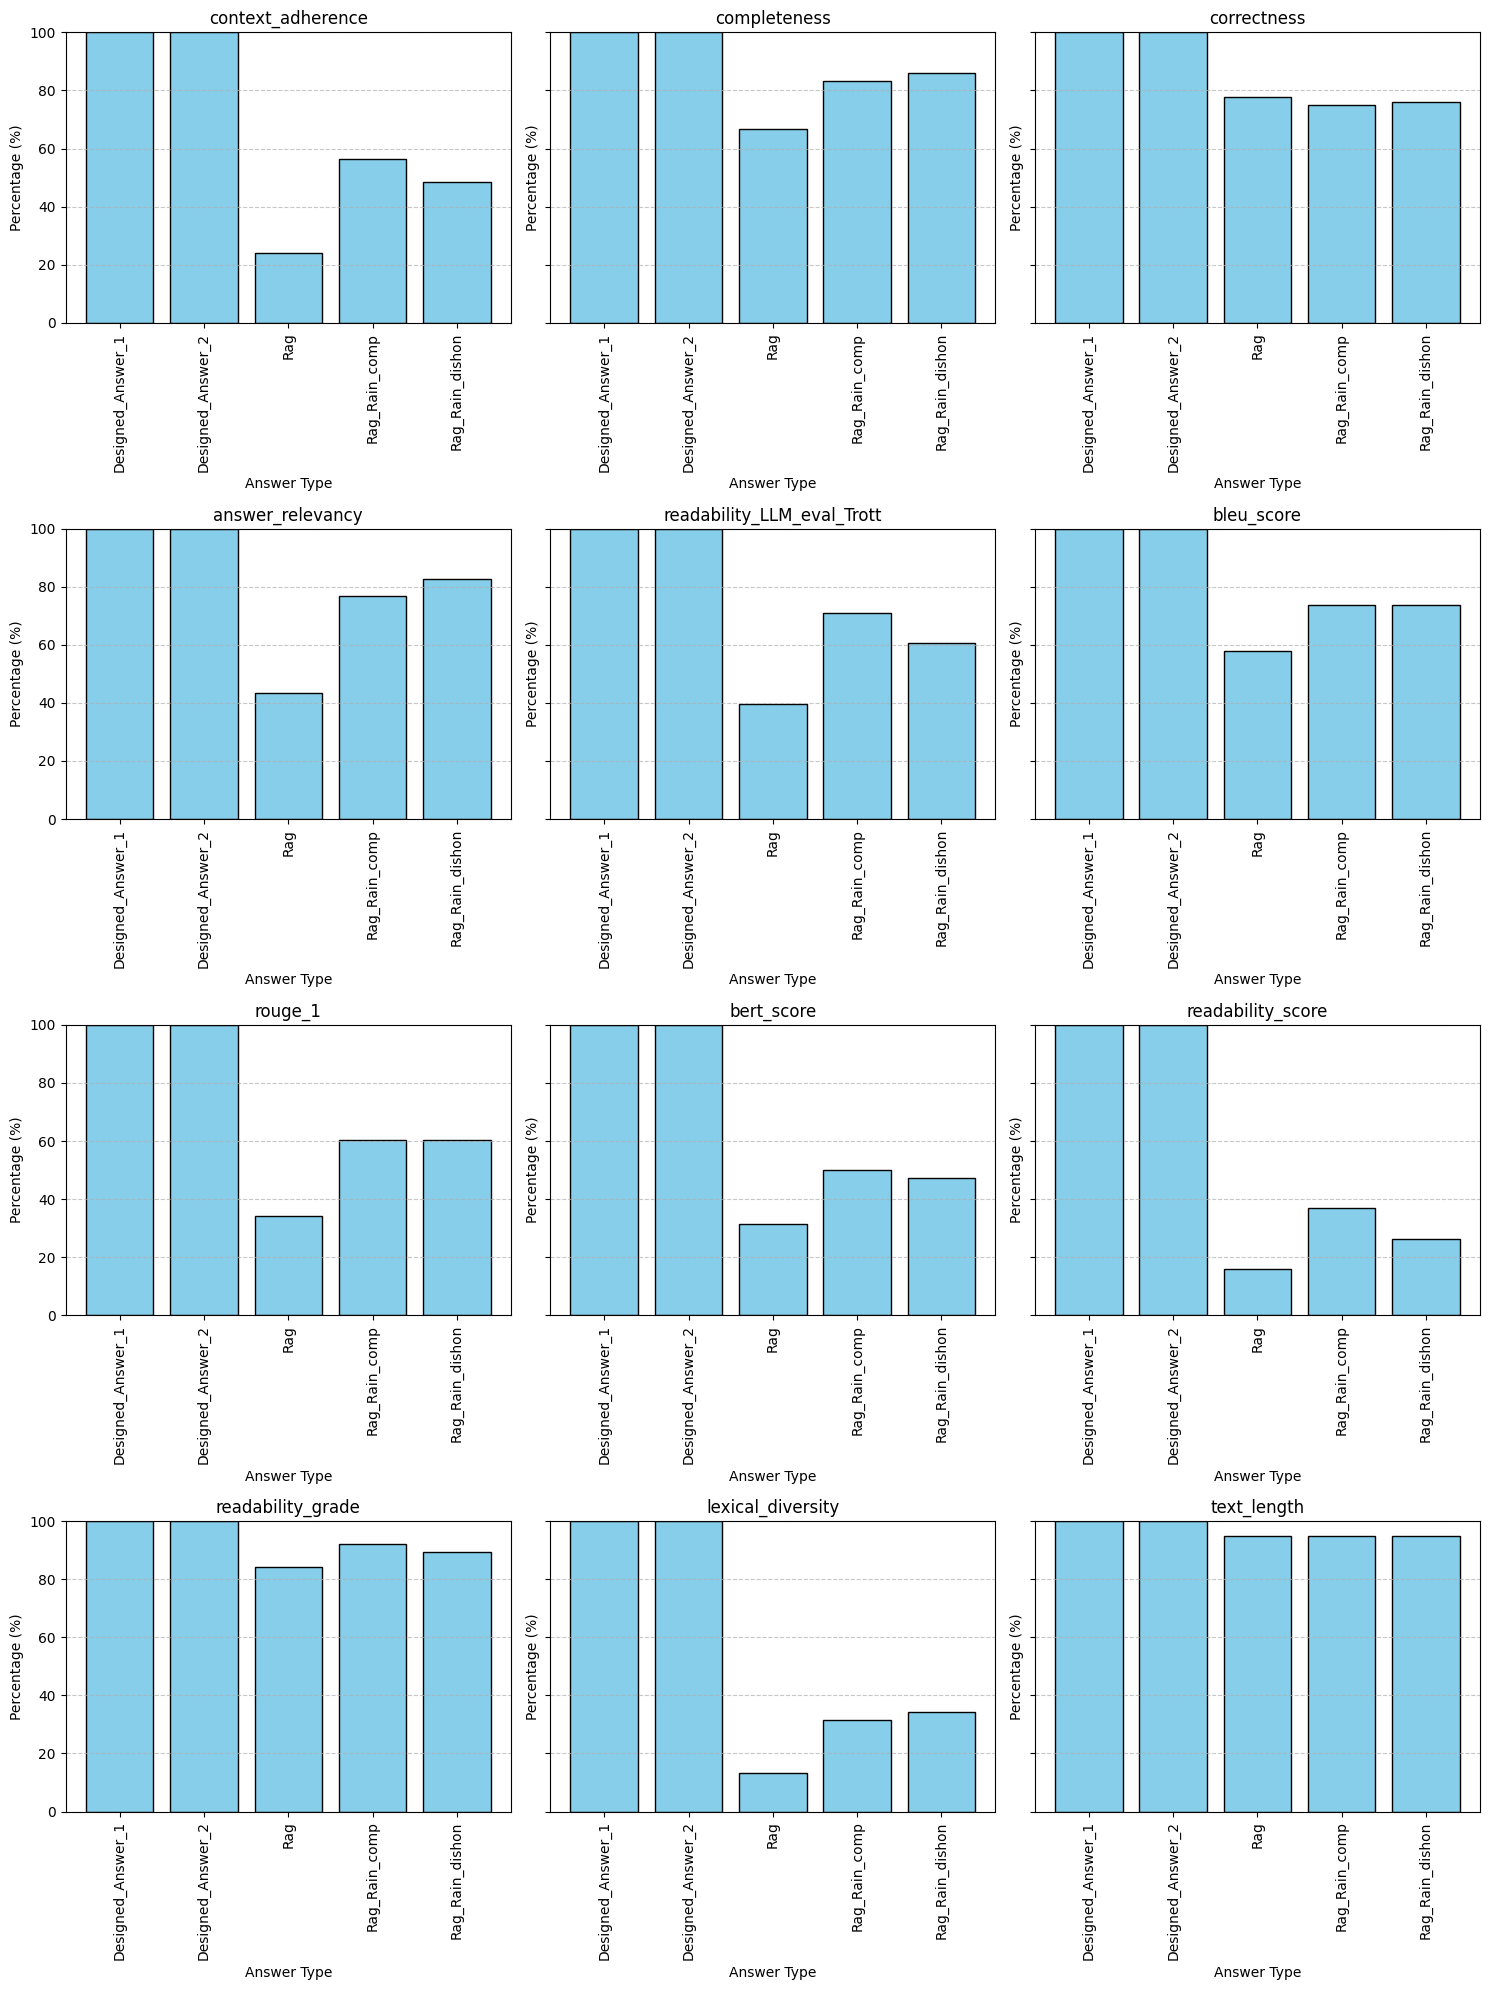

In [21]:
import matplotlib.pyplot as plt

# Number of metrics
num_metrics = len(metrics)

# Define the number of rows and columns for subplots
# Adjust these values based on the number of metrics
num_rows = (num_metrics + 2) // 3  # Example: 3 columns, adjust as needed
num_cols = min(num_metrics, 3)     # Example: up to 3 plots per row

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5), sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each metric
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    ax.bar(percentage_df.index, percentage_df[metric], color='skyblue', edgecolor='black')
    ax.set_xlabel('Answer Type')
    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'{metric}')
    ax.set_ylim(0, 100)  # Set y-axis limits from 0 to 100
    ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines
    
    # Rotate x-axis labels by 90 degrees for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Remove any unused subplots
for idx in range(len(metrics), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()

# Save the plot as an image file (optional)
plt.savefig('percentage_comparison.png')

# Show the plot
plt.show()